# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [1]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

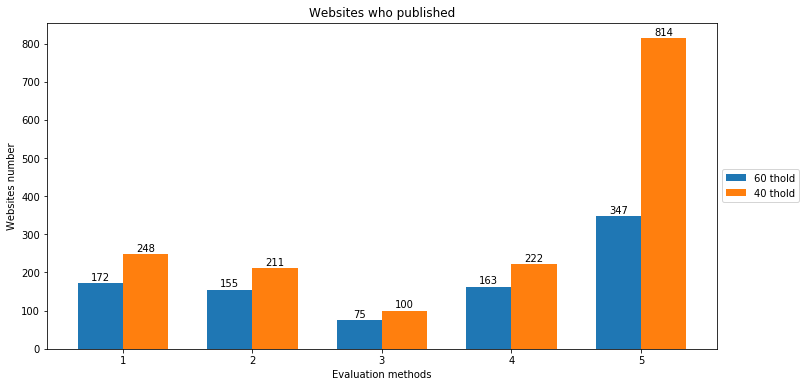

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

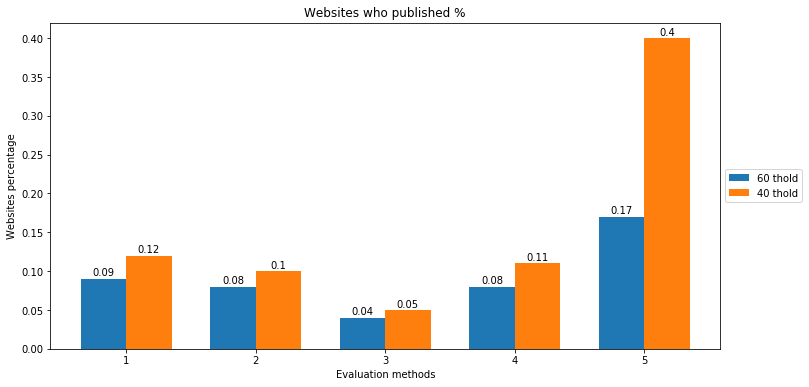

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

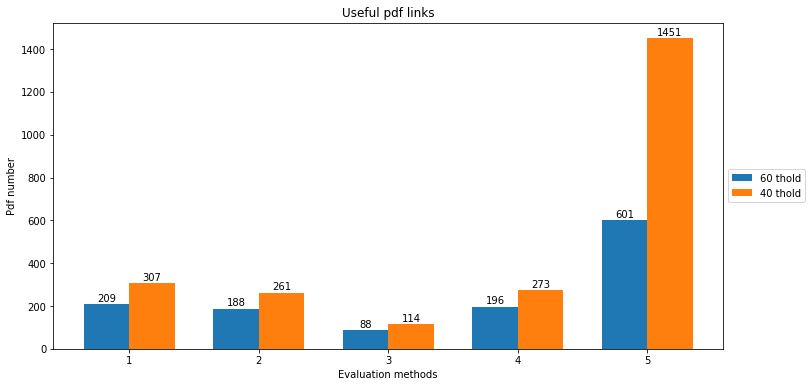

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

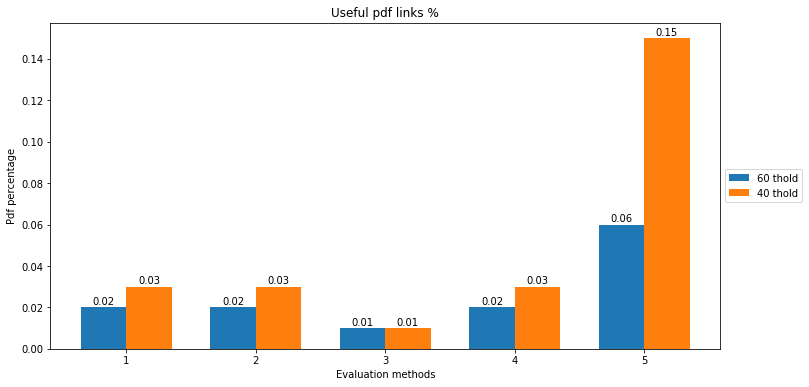

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

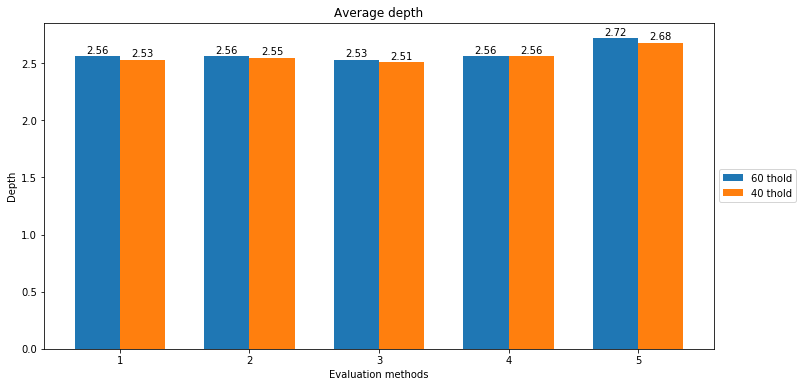

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

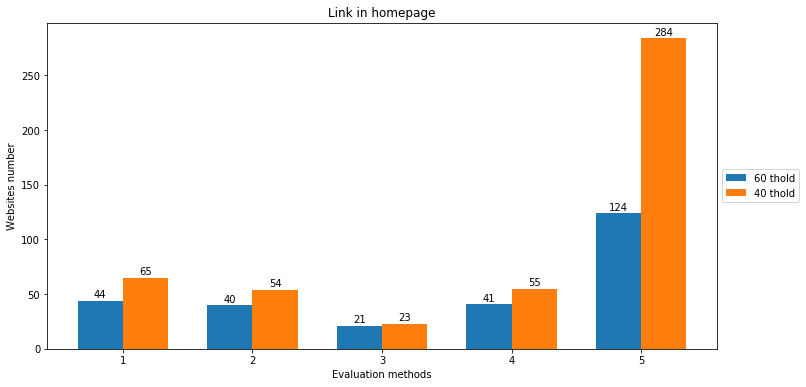

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


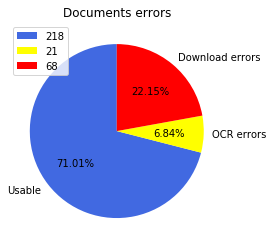

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'
val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'r']

fig1, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
ax.set_title("Documents errors")
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

La popolazione dell'indice si basa su richieste alle API Atoka e Dandelion.
È possibile che alcuni report siano stati pubblicati da aziende le cui informazioni non sono completamente reperibili tramite Atoka, ci sono quindi alcuni documenti elastic incompleti, che presentano ad esempio la mancanza dell'indirizzo dell'azienda, del codice ateco, dei ricavi o del numero di dipendenti.

Companies in index: 170


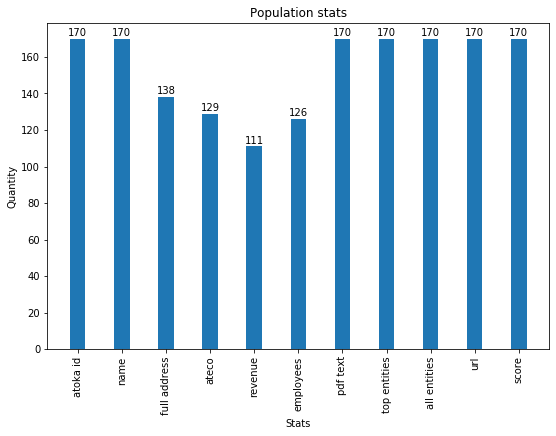

In [13]:
from elasticsearch_utilities import generate_plot

stats_path = "elasticsearch_utilities/stats/population.csv"
generate_plot(stats_path)
print("Companies in index: 170")
plt.show()

# Analisi: Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, che quelle principali.

# Modelli su tutte le entità

Il numero di entità presente per ogni documento è abbastanza alto, in media sono presenti __2496__ entità.

È stato creato un modello con l'insieme completo di entità, senza alcun vincolo, poi sono stati considerati dei vincoli di frequenza tra documenti e all'interno di un singolo documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta vicoli sulle keyword, si cercano quindi i topics considerando la lista completa di entità estratte dal testo.

### Preprocessing
Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. _dtm_tf_ : frequency vector
2. _tf_vectorizer_ : count vectorizer contentente il vocabolario estratto dai documenti

In [18]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [5]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

### Parametri 
Nella creazione del modello bisogna tenere conto del numero di argomenti da trovare e di due parametri alpha e beta.

I valori di __alpha__ e __beta__ controllano rispettivamente:
1. quanti topics fanno parte di un documento: per un valore basso si assume che ogni documento sia composto da pochi topics 
2. quante parole compongono ogni topic: un valore più basso fa assumere al modello che ogni topic sia composto da poche keyword specifiche.
    
Per il primo caso, non avendo restrizioni sulla frequenza nei documenti e avendo tutte le entità per ogni testo, si assume che:
1. i topics presenti siano tanti
2. i testi siano composti da non troppi topics rispetto al totale 
3. ogni topic usi un sottoinsieme non troppo grande della totalità delle keyword nel vocabolario 

In [20]:
%%capture
from sklearn.decomposition import LatentDirichletAllocation

topics = 7
alpha = 0.3
beta = 0.2

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)

### Visualizzazione

I topics trovati sono visualizzati con pyLDAvis.

In [21]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.125678  0.088404       1        1  30.729590
4      0.223821  0.047868       2        1  24.244590
3     -0.116522  0.159632       3        1  14.263133
0     -0.099758  0.089958       4        1   9.481901
2     -0.076574 -0.229871       5        1   8.708909
5     -0.125697 -0.135282       6        1   7.171563
6      0.320409 -0.020709       7        1   5.400315, topic_info=                      Term         Freq        Total Category  logprob  \
10126               henkel  2810.000000  2810.000000  Default  30.0000   
7198            employment  7411.000000  7411.000000  Default  29.0000   
8278               finance  3278.000000  3278.000000  Default  28.0000   
7377          environment_  1856.000000  1856.000000  Default  27.0000   
2723               biology  2000.000000  2000.000000  Default  26.0000   
...                    ...          ...          ...      ...      ...   
16949            pollution   115.945075   351.702908   Topic7  -5.3660   
23933                water   143.559450  1245.755404   Topic7  -5.1524   
6803               ecology    98.126937   282.639707   Topic7  -5.5329   
7724        european_union   114.340133  1180.185550   Topic7  -5.3800   
19438  scientific_research   102.646234   499.361933   Topic7  -5.4878   

       loglift  
10126  30.0000  
7198   29.0000  
8278   28.0000  
7377   27.0000  
2723   26.0000  
...        ...  
16949   1.8090  
23933   0.7580  
6803    1.8608  
7724    0.5845  
19438   1.3367  

[512 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
41         1  0.048661                 18p
41         4  0.016220                 18p
41         5  0.940785                 18p
315        3  0.961831          _decathlon
378        7  0.995227              _nagel
...      ...       ...                 ...
24572      4  0.996116             zermelo
24584      1  0.005002  zf_friedrichshafen
24584      3  0.005002  zf_friedrichshafen
24584      4  0.985357  zf_friedrichshafen
24603      7  0.995485               zogno

[1126 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3, 6, 7])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue sono stati impostati dei vincoli di frequenza, un' entità viene considerata a patto che:
1. compaia in almeno __N__ documenti distinti
2. compaia almeno __M__ volte all'interno di un documento

L'obiettivo è quello di scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio e quei termini secondari all'interno di un documento.

### Grandezza vocabolario

A seguire la grandezza del vocabolario in relazione ai valori __N__ ed __M__.

Tenendo presente che:
- il totale dei documenti è di _170_.
- il numero medio di entità trovate in un testo è di _2496_

si può notare che anche valori molto piccoli di N ed M riducono di molto la grandezza del vocabolario.

Il grafico non presenta l'andamento completo, ma solo la parte iniziale in cui si nota un decremento esponenziale della dimensione.

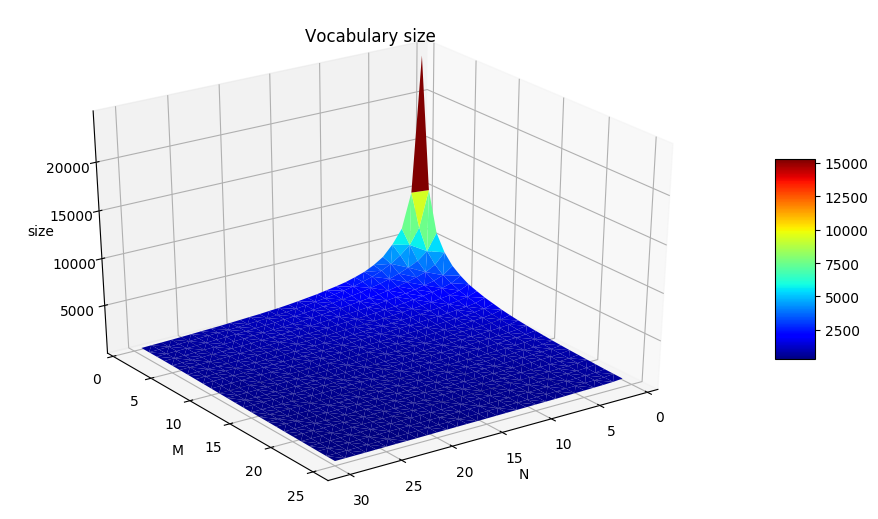

In [3]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

### Modello

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le __restrizioni__ discusse sopra.

Avendo una restrizione sulla frequenza, è opportuno cambiare i parametri del modello, in particolare:
1. si cercano __meno topics__, poichè con il vincolo di frequenza si eliminano gli argomenti troppo specifici per ogni documento
2. i documenti saranno __composti da più topics__ sul totale rispetto al caso precedente
3. non cambia la grandezza di ogni topic

A seguire il modello che considera solo i termini presenti in almeno il __50%__ dei __documenti__ e presenti almeno __20__ volte all'interno di un singolo documento.

Cambiando i paramentri del modello e includendo il constraint sulla frequenza si possono notare topic più distinti.

In [23]:
from lda_topic_model import preprocess_freq_count

N = round(170 * 0.5)
M = 20

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

topics = 4
alpha = 0.8
beta = 0.4
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 69 

Words:

'sustainability' : 55
'sustainable_development' : 56
'company' : 8
'economy' : 16
'technology' : 57
'raw_material' : 46
'energy' : 19
'board_of_directors' : 2
'recycling' : 47
'environmental_impact_assessment' : 20
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.093587  0.202479       1        1  52.979088
2      0.253098  0.020138       2        1  20.305992
3     -0.194294 -0.094274       3        1  15.391119
0      0.034784 -0.128343       4        1  11.323801, topic_info=                       Term         Freq        Total Category  logprob  \
8                   company  4890.000000  4890.000000  Default  30.0000   
2        board_of_directors  1813.000000  1813.000000  Default  29.0000   
55           sustainability  9233.000000  9233.000000  Default  28.0000   
35               investment  1109.000000  1109.000000  Default  27.0000   
23                     euro  2222.000000  2222.000000  Default  26.0000   
..                      ...          ...          ...      ...      ...   
39               management    76.273276  3064.401662   Topic4  -4.4712   
56  sustainable_development    25.274048  1059.204244   Topic4  -5.5757   
55           sustainability   167.732989  9233.809048   Topic4  -3.6831   
49                     risk    25.945252  1336.935762   Topic4  -5.5495   
2        board_of_directors    18.582088  1813.775679   Topic4  -5.8833   

    loglift  
8   30.0000  
2   29.0000  
55  28.0000  
35  27.0000  
23  26.0000  
..      ...  
39  -1.5150  
56  -1.5572  
55  -1.8300  
49  -1.7639  
2   -2.4027  

[168 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.998521       air_pollution
0         4  0.001288       air_pollution
1         1  0.990131            behavior
1         4  0.005501            behavior
2         1  0.124051  board_of_directors
...     ...       ...                 ...
66        3  0.277676               water
66        4  0.475823               water
67        1  0.652568             welfare
67        4  0.314199             welfare
68        3  0.940369               world

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di entità principali.

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei modelli più specifici.

Anche in questo caso è inizialmente considerato l'insieme totale di entità e successivamente quello ristretto per frequenza.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà. Bisogna però tenere presente che il numero medio di entità principali per ogni testo è di 250, molto minore di 2496, ottenuto come media del numero di entità complete.

In [6]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")
print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


Per la scelta dei parametri nel modello, si è __ridotto__ il numero di __topics__, __aumentando__ i valori di __alpha__ e __beta__ rispetto al modello su tutte le entità.

In [25]:
topics = 5
alpha = 0.45
beta = 0.55

lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.094609  0.116192       1        1  43.126322
3      0.124825  0.039345       2        1  39.438627
4      0.061288 -0.010118       3        1  13.157857
1     -0.053708 -0.075759       4        1   3.413830
0     -0.037796 -0.069659       5        1   0.863364, topic_info=                       Term        Freq       Total Category  logprob  loglift
7796                  right  147.000000  147.000000  Default  30.0000  30.0000
1245               business  233.000000  233.000000  Default  29.0000  29.0000
3356                finance  174.000000  174.000000  Default  28.0000  28.0000
2889             employment   71.000000   71.000000  Default  27.0000  27.0000
2973           environment_   58.000000   58.000000  Default  26.0000  26.0000
...                     ...         ...         ...      ...      ...      ...
4367  identification_number    0.101736    1.864752   Topic5  -8.2748   1.8436
6305    occupational_health    0.101736    1.864752   Topic5  -8.2748   1.8436
1903              companies    0.101736    1.864752   Topic5  -8.2748   1.8436
5494       managementsystem    0.101736    1.864752   Topic5  -8.2748   1.8436
9988      water_consumption    0.101736    1.864752   Topic5  -8.2748   1.8436

[386 rows x 6 columns], token_table=       Topic      Freq                       Term
term                                             
191        2  0.949127                   accident
201        1  0.235227                 accounting
201        2  0.470455                 accounting
201        3  0.277996                 accounting
202        3  0.610415        accounting_standard
...      ...       ...                        ...
10148      2  0.917856               working_time
10148      3  0.070604               working_time
10150      2  0.939748                   workshop
10162      2  0.597270  world_health_organization
10162      4  0.199090  world_health_organization

[537 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 2, 1])

## Modello con vincoli di frequenza - entità principali

Si può notare che l'andamento della grandezza del vocabolario in funzione alle grandezze delle restrizioni applicate è simile al caso precedente.

Osservando però il parametro M, che regola il numero di occorrenze all'interno dello stesso documento, si nota che basta un valore molto piccolo a far arrivare la grandezza del vocabolario a zero.

Il modello successivo perciò non imporrà un vincolo di frequenza paragonabile al modello con la lista di entità complete, per evitare di trovarsi con un vocabolario troppo piccolo.

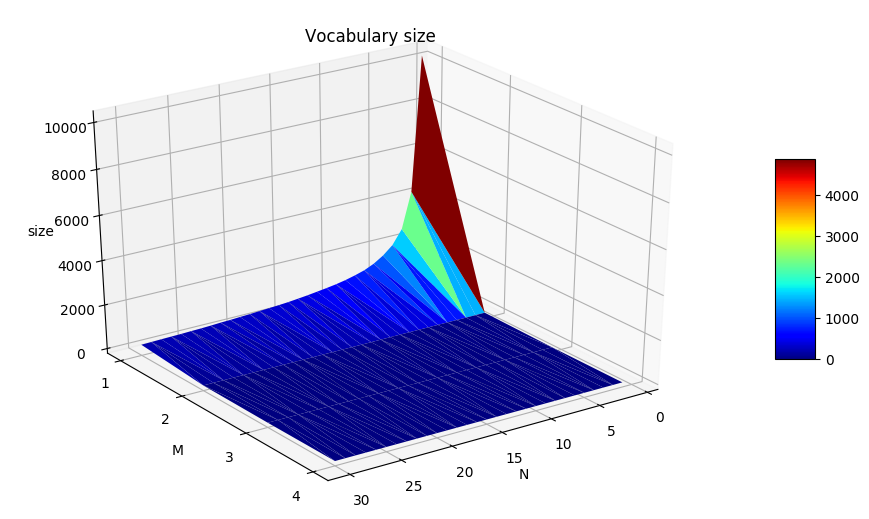

In [7]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path, en="top")
plt.show()

A seguire due modelli con un valore N equivalente al 50 % dei documenti nell'indice, e un valore M di 1 e 2 rispettivamente, per evitare di ridurre il vocabolario a zero.
### M = 1

Nel modello:
1. sono stati __ridotti__ i __topics__ ricercati
2. è __aumentato__ il valore di __alpha__, tenendo conto della presenza di più topics nei singoli documenti 

In [28]:
topics = 3
alpha = 0.8
beta = 0.1
lda = LatentDirichletAllocation(n_components = topics, 
                                doc_topic_prior= alpha, 
                                topic_word_prior = beta, 
                                random_state=0)

N = round(170 * 0.5)
M = 1
dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 44 

Words:

'technology' : 36
'water' : 43
'policy' : 26
'management' : 24
'training' : 38
'information' : 20
'investment' : 22
'company' : 6
'waste' : 41
'industry' : 19
...


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.085363  0.004617       1        1  33.772504
2     -0.034633 -0.039032       2        1  33.604322
0     -0.050730  0.034415       3        1  32.623174, topic_info=                Term        Freq       Total Category  logprob  loglift
15              euro  100.000000  100.000000  Default  30.0000  30.0000
21        innovation   97.000000   97.000000  Default  29.0000  29.0000
32   standardization   88.000000   88.000000  Default  28.0000  28.0000
12         economics   88.000000   88.000000  Default  27.0000  27.0000
3   business_process   87.000000   87.000000  Default  26.0000  26.0000
..               ...         ...         ...      ...      ...      ...
24        management   44.678484  177.431613   Topic3  -3.5372  -0.2589
39         transport   20.211222   85.025652   Topic3  -4.3304  -0.3166
36        technology   28.560482  125.941110   Topic3  -3.9846  -0.3636
17    european_union   25.298953  117.461095   Topic3  -4.1059  -0.4152
23               law   23.215003  112.139876   Topic3  -4.1919  -0.4548

[124 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         1  0.078262            behavior
0         2  0.290687            behavior
0         3  0.637276            behavior
1         1  0.147245  board_of_directors
1         2  0.645612  board_of_directors
...     ...       ...                 ...
42        2  0.332262    waste_management
42        3  0.503753    waste_management
43        1  0.296789               water
43        2  0.366040               water
43        3  0.336361               water

[132 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### M = 2

Il modello è lo stesso del precedente, cambia il vincolo M.

In [29]:
M = 2
dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_top_entities_en.csv", N, M)
print_vocab(tf_vectorizer.vocabulary_)

lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

Total words in vocabulary : 10 

Words:

'management' : 4
'business' : 0
'contract' : 1
'sustainability' : 6
'european_union' : 3
'corporation' : 2
'waste' : 8
'policy' : 5
'waste_management' : 9
'training' : 7


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.017224 -0.167889       1        1  41.826043
0     -0.222657  0.073812       2        1  31.800209
2      0.205434  0.094077       3        1  26.373748, topic_info=               Term       Freq      Total Category  logprob  loglift
1          contract  17.000000  17.000000  Default  10.0000  10.0000
0          business  17.000000  17.000000  Default   9.0000   9.0000
5            policy   4.000000   4.000000  Default   8.0000   8.0000
4        management  59.000000  59.000000  Default   7.0000   7.0000
6    sustainability   5.000000   5.000000  Default   6.0000   6.0000
9  waste_management   2.000000   2.000000  Default   5.0000   5.0000
8             waste   2.000000   2.000000  Default   4.0000   4.0000
2       corporation   2.000000   2.000000  Default   3.0000   3.0000
7          training   1.000000   1.000000  Default   2.0000   2.0000
3    european_union   1.000000   1.000000  Default   1.0000   1.0000
6    sustainability   4.962404   5.193110   Topic1  -2.2800   0.8262
7          training   1.708362   1.939039   Topic1  -3.3464   0.7450
3    european_union   1.708326   1.939060   Topic1  -3.3464   0.7450
4        management  39.650983  59.682560   Topic1  -0.2018   0.4627
2       corporation   0.081354   2.429614   Topic1  -6.3909  -2.5250
8             waste   0.081354   2.429614   Topic1  -6.3909  -2.5250
9  waste_management   0.081354   2.807359   Topic1  -6.3909  -2.6695
5            policy   0.081356   4.547225   Topic1  -6.3909  -3.1518
0          business   0.081358  17.252902   Topic1  -6.3908  -4.4852
1          contract   0.081357  17.779518   Topic1  -6.3908  -4.5153
0          business  17.046762  17.252902   Topic2  -0.7719   1.1337
5            policy   4.341094   4.547225   Topic2  -2.1398   1.0993
8             waste   2.223480   2.429614   Topic2  -2.8088   1.0570
2       corporation   2.223480   2.429614   Topic2  -2.8088   1.0570
4        management  10.523977  59.682560   Topic2  -1.2542  -0.5897
7          training   0.105891   1.939039   Topic2  -5.8532  -1.7618
3    european_union   0.105888   1.939060   Topic2  -5.8533  -1.7619
9  waste_management   0.105885   2.807359   Topic2  -5.8533  -2.1319
6    sustainability   0.105899   5.193110   Topic2  -5.8532  -2.7469
1          contract   0.105887  17.779518   Topic2  -5.8533  -3.9777
1          contract  17.592274  17.779518   Topic3  -0.5533   1.3222
9  waste_management   2.620120   2.807359   Topic3  -2.4576   1.2638
4        management   9.507600  59.682560   Topic3  -1.1687  -0.5041
3    european_union   0.124846   1.939060   Topic3  -5.5015  -1.4101
7          training   0.124786   1.939039   Topic3  -5.5019  -1.4105
2       corporation   0.124779   2.429614   Topic3  -5.5020  -1.6361
8             waste   0.124779   2.429614   Topic3  -5.5020  -1.6361
5            policy   0.124775   4.547225   Topic3  -5.5020  -2.2630
6    sustainability   0.124807   5.193110   Topic3  -5.5018  -2.3955
0          business   0.124782  17.252902   Topic3  -5.5020  -3.5964, token_table=      Topic      Freq              Term
term                                   
0         2  0.985341          business
1         3  1.012401          contract
2         2  0.823176       corporation
3         1  1.031428    european_union
4         1  0.670213        management
4         2  0.184308        management
4         3  0.167553        management
5         2  0.879657            policy
6         1  0.962814    sustainability
7         1  1.031439          training
8         2  0.823176             waste
9         3  1.068620  waste_management, R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])